## Jet analysis

In [1]:
import numpy as np
from astropy.io import ascii, fits
from ants import fluxInt, pbCorr, synCl, fitSource
from prettytable import PrettyTable
import shutil,os, string

from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib import gridspec
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, LogLocator
import matplotlib.ticker
from matplotlib import transforms as mtransforms
from matplotlib.ticker import LogLocator, FormatStrFormatter
from matplotlib.ticker import StrMethodFormatter

C = 2.99792458e8


ftSrc = fitSource.fitsrc()
fint = fluxInt.fluxint()

#rootdir
rootDir = '/Users/maccagni/Projects/MFS/FornaxA/contData/core/'
#rootDir = '/home/maccagni/Projects/MFS/FornaxA/contData/core/'

#label

aut='F8'

subRegions = ['cjet/','centre/','jet/']
labelReg = ['cjFine','cFine','jFine']
jCount = [8,5,7]

imDir = rootDir+'inIms/'
fint.rootdir = imDir

regDir = imDir+'inReg/'
outTabs = rootDir+'outTabs/'
figDir = rootDir+'coreFigs/'

#input image
inIm = imDir+'Meer_1440MHz_pbcorr_cutCtr.fits'
noise = 0.
errFlux = 15.

#output table 
labelDim = ['1D']
outTables = [outTabs+'jCjFluxWidth'+labelDim[0]+'.tbl']

beta = 0.2
alpha =0.6
#-------------------------------------------------#
# Jet and counter-jet flux ratio
#-------------------------------------------------#
def splitter(A):
    B = A[0:len(A)//2]
    C = A[len(A)//2:]

    return (B,C)


print '''\n\t+---------+\n\t Inputs loaded\n\t+---------+'''



	+---------+
	 Inputs loaded
	+---------+


In [2]:
#-------------------------------------------------#
# Jet and counter-jet analysis
#-------------------------------------------------#
def gauss1D( x, amp, xc, sigma):

        return amp*np.exp( -(x-xc)**2 / (2*sigma**2)) / np.sqrt(2*np.pi*sigma**2)

datas,heads = fint.openFile(inIm)
#Regions where to measure flux
for i in xrange(0,len(labelDim)):
    if os.path.exists(outTables[i]):
        os.remove(outTables[i])

fr=[]
flIntBeamArray=[]
flErrBeamArray=[]
flIntOutArray=[]
flErrOutArray=[]

for i in xrange(0,len(subRegions)):
#for i in xrange(0,1):

#    for j in xrange(0,1):

    for j in xrange(0,jCount[i]):
        dd = datas.copy()

        region = regDir+subRegions[i]+labelReg[i]+str(j)+'.reg'

        maskedData, background, rms, pixels=fint.maskDatReg(dd,heads,region,noise)


        fits.writeto(rootDir+str(j)+'_mask_jCj.fits',maskedData,heads,overwrite=True)

        maskedData[maskedData==0.0] = np.nan
        fluxint, numPixBeam =fint.measFlux(maskedData,heads,errFlux,'none')

        #maskedData[np.isnan(maskedData)] = 0.0

        #params2D = ftSrc.fit2Dgaussian(maskedData)

        #params2D = ftSrc.fitgauss2D(maskedData)
        #print params2D

        compressedData = np.nanmean(maskedData,axis=1)
        print np.nanmax(compressedData)

        compressedData[np.isnan(compressedData)] = 0.0        

        peakIm = np.nanmax(compressedData)
        print peakIm
        compressedData= compressedData[compressedData != 0]
        params1D = ftSrc.gaus1Dfit(compressedData)
        params1D = ftSrc.fitgauss1D(compressedData)
        print params1D


        plt.figure(figsize=(8,4))
        x=np.arange(compressedData.shape[0])
        plt.plot(x, compressedData, linewidth=5, color='k', label='original')
        plt.plot(x, gauss1D(x, *params1D), linewidth=3, color='r', label='fit')#
        plt.legend()
        plt.show()

        regionName =  string.split(region,'/')[-1]

        #params2D = np.insert(params2D,0,peakIm)
        #params2D = np.insert(params2D,0,fluxint)

        params1D = np.insert(params1D,0,peakIm)
        params1D = np.insert(params1D,0,fluxint)

        params1D[2]= params1D[2]/np.sqrt(2*np.pi*params1D[4]**2)

        #params2D[2]= params2D[2]/np.sqrt(2*np.pi*params2D[4]**2)

        for k in xrange(0,len(labelDim)):
            if k==0:
                t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
           # elif k==1:
            #    t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)

widthBeam = heads['BMAJ']*3600. 
print widthBeam
for i in xrange(0,len(labelDim)):

    table= ascii.read(outTables[i])
    #define parameters
    width = table['width X']*2.355*heads['CDELT2']*3600. #from sigma in pix to fwhm in arcsec. 
    widthReal = width.copy()
    for j in xrange(0,len(width)):
        if width[j]>=widthBeam:
            widthReal[j] = np.sqrt(np.power(width[j],2)-np.power(widthBeam,2))
        else:
            widthReal[j] = widthBeam

    surfBright = table['PeakGaus']*np.sqrt((np.power(widthReal,2)/np.power(widthBeam,2)+1))
    surfBrightErr = (surfBright/0.02)

    deconvolvedWidthErr = widthReal*(1./widthReal)+6.7/3.

    table.add_column(surfBright, name='surfaceBrightness')
    table.add_column(surfBright, name='surfaceBrightnessErr')

    table.add_column(widthReal, name='deconvolvedWidth')
    table.add_column(deconvolvedWidthErr, name='deconvolvedWidthErr')

    ascii.write(table,outTables[i], overwrite=True)

    #for k in xrange(0,len(labelDim)):
    #    if k==0:
    #       t = ftSrc.writeGaus1DfitTable(regionName,outTables[k],params1D)
    #    elif k==1:
    #        t = ftSrc.writeGaus2DfitTable(regionName,outTables[k],params2D)


print '''\\t+---------+\\n\\t Flux & size variation along jet\\n\\t+---------+'''

AttributeError: fluxint instance has no attribute 'openFile'

In [42]:
def ticks_format(value, index):
    '''
    get the value and returns the value as:
       integer: [0,99]
       1 digit float: [0.1, 0.99]
       n*10^m: otherwise
    To have all the number of the same size they are all returned as latex strings
    '''
    exp = np.floor(np.log10(value))
    base = value/10**exp
    if exp == 0 or exp == 1:   
        return '${0:d}$'.format(int(value))
    if exp == -1:
        return '${0:.1f}$'.format(value)
    if exp == -2:
        return '${0:.2f}$'.format(value)
    if exp == -3:
        return '${0:.3f}$'.format(value)
    if exp == -4:
        return '${0:.4f}$'.format(value)
    else:
        return '${0:d}\\\\times10^{{{1:d}}}$'.format(int(base), int(exp))

def jCjPlot(radius,brightJet,brightJetErr, brightCJet,brightCJetErr,sizeJet,sizeJetErr,sizeCJet,sizeCJetErr,
            ratio,ratioErr,width,m,b,outfile):

    params = {'font.family'         :' serif',
              'font.serif'          :'times new roman',
              'font.style'          : 'normal',
              'font.weight'         : 'book',
              'font.size'           : 13.5,
              'axes.linewidth'      : 1.5,
              'lines.linewidth'     : 2,
              'xtick.labelsize'     : 12,
              'ytick.labelsize'     : 12, 
              'xtick.direction'     :'in',
              'ytick.direction'     :'in',
              'xtick.top'           : True,   # draw ticks on the top side
              'xtick.bottom'        : True,   # draw ticks on the bottom side    
              'ytick.left'          : True,   # draw ticks on the top side
              'ytick.right'         : True,   # draw ticks on the bottom side  
              'xtick.major.size'    : 6,
              'xtick.major.width'   : 1,
              'xtick.minor.size'    : 3,
              'xtick.minor.width'   : 1,
              'ytick.major.size'    : 6,
              'ytick.major.width'   : 1,
              'ytick.minor.size'    : 3,
              'ytick.minor.width'   : 1, 
              'text.usetex'         : True,
              'text.latex.unicode'  : True
               }
    plt.rcParams.update(params)

    # initialize figure
    fig = plt.figure(figsize=(10,10))

    #fig.subplots_adjust(hspace=0.1,wspace=0.1)
    gs = gridspec.GridSpec(2, 2)
    plt.rc('xtick')

    # Initialize subplots
    ax1 = fig.add_subplot(gs[0,0])
    ax1.set_xlabel(r'radius [kpc]')
    ax1.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    ax1.set_xscale('log', nonposx='clip')
    ax1.set_yscale('log', nonposy='clip')

    #ax1.set_linewidth(2)
    ax1.tick_params(axis='both', which='major', pad=5)

    #ax1.yaxis.set_major_locator(LogLocator(base=10,subs=[1e-4,1e-3,1e-2]))
    #ax1.xaxis.set_major_locator(LogLocator(base=10,subs=[1e-1]))    

    ax1.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax1.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,3.0,6.0]))

    ax1.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax1.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax1.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax1.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))     
    ax1.set_ylim(0.001,0.2)

    #sf = matplotlib.ticker.ScalarFormatter()

    #ax1.get_xaxis().set_major_formatter(sf)
    #ax1.get_yaxis().set_major_formatter(sf)

    ax1.plot(radius[:-2],brightJet[:-2],lw=2, marker='o', color='blue', linestyle=' ',label='jet',alpha=1,
             markersize=8)
    ax1.plot(radius[:-2],brightCJet[:-2],markeredgewidth=2, marker='s', markeredgecolor='red', 
             linestyle=' ',markerfacecolor='None',label='counter-jet',alpha=1,
             markersize=8)
    ax1.axvline(2.5,ls='--',c='k',lw=1.3,alpha=0.8)

    labels=ax1.get_xticks().tolist()
    labels = [item.get_text() for item in ax1.get_xticklabels()]
    #labels[0] = '10'
    #labels[1] = '20'
    #labels[2] = '30'
    #labels[3] = '40'

    #ax1.set_xticklabels(labels)
    #ax1.set_xticklabels(['6', '10', '15','20'])

    #ax1.legend = plt.legend(loc=1, prop={'size': 20})
    #ax1.legend.get_frame().set_edgecolor('black')


    ax2 = fig.add_subplot(gs[1,1])

    ax2.set_xlabel(r'radius [kpc]')
    ax2.set_ylabel(r'$w$ [arcsec]')
    ax2.set_yscale('log', nonposy='clip')
    ax2.set_xscale('log', nonposx='clip')

    ax2.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax2.yaxis.set_minor_locator(LogLocator(base=10,subs=[0.7,1.0,1.3,1.6,2.0,3.0,4.0]))

    ax2.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax2.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax2.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax2.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))     

    #ax2.set_ylim(0,40)
   # ax2.set_xlim(0,80)

    ax2.tick_params(axis='both', which='major', pad=5)

    ax2.plot(radius[:-2],sizeJet[:-2],lw=2, marker='o', color='blue', linestyle=' ',label='jet',alpha=1,
             markersize=8)

    ax2.plot(radius[:-2],sizeCJet[:-2],markeredgewidth=2, marker='s', markeredgecolor='red', 
             linestyle=' ',markerfacecolor='None',label='counter-jet',alpha=1,
             markersize=8)
    ax2.axvline(2.5,ls='--',c='k',lw=1.3,alpha=0.8)

    #ax2.legend = plt.legend(loc=2, prop={'size': 20})
    #ax2.legend.get_frame().set_edgecolor('black')

    ax3 = fig.add_subplot(gs[1,0])
    ax3.set_xlabel(r'radius [kpc]')
    ax3.set_ylabel(r'$I_{\rm j}/I_{\rm cj}$')
    ax3.set_xscale('log', nonposx='clip')

    ax3.set_yscale('log', nonposy='clip')
    ax3.tick_params(axis='both', which='major', pad=5)

    ax3.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0,5.0]))
    ax3.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,2.0,3.0,4.0, 5.0,6.0,7.0,8.0]))

    ax3.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax3.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax3.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax3.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))   

    ax3.plot(radius[:-2],ratio[:-2],lw=3, marker='o', color='black', linestyle=' ',label='',alpha=1,
             markersize=8)  
    ax3.axvline(2.5,ls='--',c='k',lw=1.3,alpha=0.8)

    #ax3.legend = plt.legend(loc=1, prop={'size': 30})

    # Initialize subplots
    ax4 = fig.add_subplot(gs[0,1])

    ax4.set_ylabel(r'$I$ [Jy beam$^{-1}$]')
    ax4.set_xlabel(r'$w$ [arcsec]')
    ax4.set_xscale('log', nonposx='clip')
    ax4.set_yscale('log', nonposy='clip')
    ax4.tick_params(axis='both', which='major', pad=5)
    ax4.set_ylim(0.001,0.2)
    ax4.set_xlim(4,25)
    ax4.xaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,1.5,2.0]))
    ax4.yaxis.set_minor_locator(LogLocator(base=10,subs=[1.0,3.0,6.0]))

    ax4.xaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax4.xaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format)) 

    ax4.yaxis.set_major_formatter(matplotlib.ticker.NullFormatter())   # remove the major ticks
    ax4.yaxis.set_minor_formatter(matplotlib.ticker.FuncFormatter(ticks_format))   
    #ax1.set_xscale(\symlog\, nonposx='clip', linthreshy=0.1)
    #ax1.set_yscale(\symlog\, nonposy='clip', linthreshy=0.1)
    #ax4.set_xlim([-0.5,1.5])
    #ax4.set_ylim([1e-2,1])
    #ax4.set_xticks([2,5,10,20,30,40])
    #ax4.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_xaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   

    #ax4.set_yticks([1e-2,2e-2,1e-1])
    #ax4.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    #ax4.get_yaxis().set_minor_formatter(matplotlib.ticker.NullFormatter())   

    #ax4.plot(ratio[0:],width[0:],lw=3, marker='o', color='black', linestyle=' ',label='',
    #         alpha=1)
    ax4.plot(sizeJet[:-2],brightJet[:-2],lw=2,marker='o',color='blue',linestyle=' ',label='jet', alpha=1,
             markersize=8)
    ax4.plot(sizeCJet[:-2],brightCJet[:-2],markeredgewidth=2,marker='s',markeredgecolor='red',
             linestyle=' ',markerfacecolor='None',label='counter-jet', alpha=1,
             markersize=8)
    
    #ax4.axvline(2.5,ls='--',c='k',lw=1.3,alpha=0.8)

    xmin = np.nanmin(sizeJet)
    xmax = np.nanmax(sizeCJet)
    x = np.linspace(xmin,xmax,1e3)
    A = .03
    y = A*np.power(x,-3./4.)

    ax4.plot(x,y,lw=2,marker=' ',color='black',linestyle='--',label='model', alpha=1)

    yy = -b*np.power(x,m)

    #ax4.plot(x,yy,lw=2,marker=' ',color='black',linestyle='-.',label='fit', alpha=1)

    ax4.legend = plt.legend(loc=1, prop={'size': 12})
    ax4.legend.get_frame().set_edgecolor('black')

    fig.tight_layout()
    # Save figure to file
    fig.savefig(outfile,
                format='pdf',dpi=300,transparent=True,bbox_inches='tight',overwrite=True)

/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in arccos
/Users/maccagni/programs/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:208: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


Jets opening angle
-1.1958907744493654


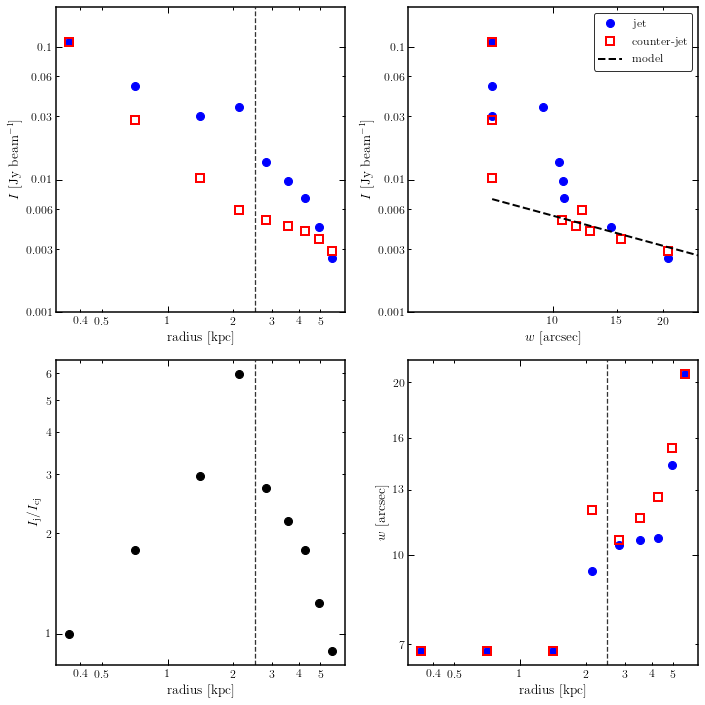

In [43]:
table= ascii.read(outTables[0])
b,c = splitter(table.columns[0])
tableCJ = table[0:len(b)+1]
tableCJrev = np.flip(tableCJ,0)

tableJ = table[len(b):]
tableJ.add_row(np.zeros(len(table.colnames))*np.nan)

widthCJ = tableCJrev['deconvolvedWidth']
widthCJ[2]=widthCJ[1]
widthCJErr = tableCJrev['deconvolvedWidthErr']

widthJ = tableJ['deconvolvedWidth']
widthJErr = tableJ['deconvolvedWidthErr']

widthRatio = np.divide(widthJ,widthCJ)
surfBrightCJ = tableCJrev['surfaceBrightness']
surfBrightCJ[2]*=2.
surfBrightCJErr = tableCJrev['surfaceBrightnessErr']
surfBrightJ = tableJ['surfaceBrightness']
surfBrightJErr = tableJ['surfaceBrightnessErr']


brightRatio = np.divide(surfBrightJ,surfBrightCJ)
brightRatioErr =brightRatio* np.sqrt(np.power(surfBrightJErr/surfBrightJ,2)+np.power(surfBrightCJErr/surfBrightCJ,2))

cosAngle = np.divide(np.power(brightRatio,1./(2.+alpha)) - 1. , 1.+np.power(brightRatio,1./(2.+alpha)))/beta

angle = np.arccos(cosAngle)*180./np.pi


print 'Jets opening angle'

radius = np.array([3.5,7,14,21,28,35,42,49,56,63,70])
radius *=101
radius /=1e3

outFig = figDir +'JetCJetAll1DTmp.pdf'

bright = np.log10(table['surfaceBrightness'])
width = np.log10(table['deconvolvedWidth'])
m,b = np.polyfit(width, bright, 1) 

print 1./b
jCjPlot(radius,surfBrightJ,surfBrightJErr,surfBrightCJ,surfBrightCJErr,widthJ,widthJErr,widthCJ,widthCJErr,
        brightRatio,brightRatioErr,widthRatio,m,b,outFig)    

In [4]:
import numpy as np

k = 1.380649e-16 #erg k-1
c =  2.99792458e10 #cm s-1
h = 6.62607015e-27 #erg s-1

nu = 8e9 #Hz
flux = 6e-3 #Jy 
fluxErg = flux*1e-23

beamX = 27.e-3/3600.
beamY = 27.e-3/3600.

beamArea = np.pi*beamX*beamY
beamAreaSr = beamArea*np.power(np.pi/180.,2)

intensity = 4*fluxErg/beamAreaSr

print intensity 

TRJ = c*c*intensity/(2*k*nu*nu)
print TRJ

T = (h*nu)/(k)/np.log(1+(2*h*np.power(nu,3))/(intensity*np.power(c,2)))
print T




4.458452120045497e-12
226742.15011614526
226742.34208713006


In [15]:
import numpy as np

k = 1.380649e-16 #erg k-1
c =  2.99792458e10 #cm s-1
h = 6.62607015e-27 #erg s-1

nu = 100e6 #Hz
flux = 1.6e4 #Jy 
fluxErg = flux*1e-23
print fluxErg
beamX = 4.3/2./60.
beamY = 4.3/2./60.

beamArea = np.pi*beamX*beamY
beamAreaSr = beamArea*np.power(np.pi/180.,2)

intensity = 4*fluxErg/beamAreaSr

print intensity 

TRJ = c*c*intensity/(2*k*nu*nu)
print TRJ

T = (h*nu)/(k)/np.log(1+(2*h*np.power(nu,3))/(intensity*np.power(c,2)))
print T




1.6e-19
5.208359426337628e-13
169523173.7807243
169523202.85164076
